In [1]:
from math import ceil

import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from pandas import DataFrame, options
from statsmodels.tsa.stattools import acf

# Suppress chained assignment warnings
options.mode.chained_assignment = None

from icefreearcticml.constants import (
    MODELS,
    MODEL_COLOURS,
    VARIABLES as VAR_NAMES,
    VAR_YLABELS,
    VAR_YLABELS_SHORT,
)
from icefreearcticml.liangindex import compute_liang
from icefreearcticml.utils import (
    calculate_bias,
    calculate_correlation_ensemble_mean,
    calculate_ensemble_mean,
    calculate_first_icefree_year,
    filter_by_years,
    get_shape_df,
    plot_variable,
    read_model_data_all,
    subtract_ensemble_mean,
)

MODEL_NAMES = MODELS[:-1]   # Exclude 'Observations' from the model names
VARIABLES_ = VAR_NAMES[:-2] # Exclude swfd and lwfd

In [2]:
model_data = read_model_data_all()

In [3]:
shapes_df = get_shape_df(model_data)
shapes_df

EC-Earth3      CESM2 MPI-ESM1-2-LR    CanESM5 ACCESS-ESM1-5  \
ssie     (131, 50)  (131, 50)     (131, 30)  (131, 49)     (131, 40)   
wsie     (131, 50)  (131, 50)     (131, 30)  (131, 49)     (131, 40)   
wsiv     (131, 50)  (131, 50)     (131, 30)  (131, 49)     (131, 40)   
tas      (131, 50)  (131, 50)     (131, 30)  (131, 49)     (131, 40)   
oht_atl  (131, 50)  (131, 50)     (131, 30)  (131, 49)     (131, 40)   
oht_pac  (131, 50)  (131, 50)     (131, 30)  (131, 49)     (131, 40)   
swfd     (131, 50)  (131, 50)     (131, 30)  (131, 49)     (131, 40)   
lwfd     (131, 50)  (131, 50)     (131, 30)  (131, 49)     (131, 40)   

        Observations  
ssie           (45,)  
wsie           (45,)  
wsiv           (45,)  
tas            (54,)  
oht_atl        (40,)  
oht_pac        (40,)  
swfd           (23,)  
lwfd           (23,)

<div lang="fr" style="display: none">
<p>Dans cette tableau, on voit les dimension de chaque jeu de données par modèle et variable. Les jeu de données d'observations sont unidimensionnels, et ils sont des périodes d'observations différentes. Tous les jeux de données des modèles sont bidimensionnels ; ils ont tous la même dimension temporelle (chacun a 131 pas de temps), mais ils différent par rapport au nombre d'ensembles. La plupart en ont 50 ; cependant, MPI-ESM1-2-LR en a 30, et ACCESS-ESM1-5 en a 40. En plus, pour les variables d'OHT, CanESM5 a 49 ensembles.<p>
</div>

<div lang="en">
<p>Here we can see the shapes for each of the datasets by model and variable. The observations datasets are 1D and have different observational periods. All model datasets are 2D, consistent across the time dimension (each has 131 time steps), but varying across the number of ensembles. Most have 50 ensembles; however, MPI-ESM1-2-LR has 30 and ACCESS-ESM1-5 has 40. In addition, CanESM5 has 49 ensembles for the OHT variables.</p>
</div>

In [4]:
observations = {var: model_data[var]['Observations'] for var in VAR_NAMES}

# Calculate the average of all model ensembles 
model_ensemble_avgs = {
    var: {
        model: calculate_ensemble_mean(model_data[var][model]) for model in MODEL_NAMES
    } for var in VARIABLES_
}

# Calculate the first icefree year based on SSIE for each model ensemble average
model_ensemble_avg_icefree_years = {
    model: calculate_first_icefree_year(model_ensemble_avgs["ssie"][model])
    for model in MODEL_NAMES
}

# Calculate the first icefree year based on SSIE for each of the model ensembles
model_ensemble_icefree_years = {
    model: calculate_first_icefree_year(model_data["ssie"][model])
    for model in MODEL_NAMES
}

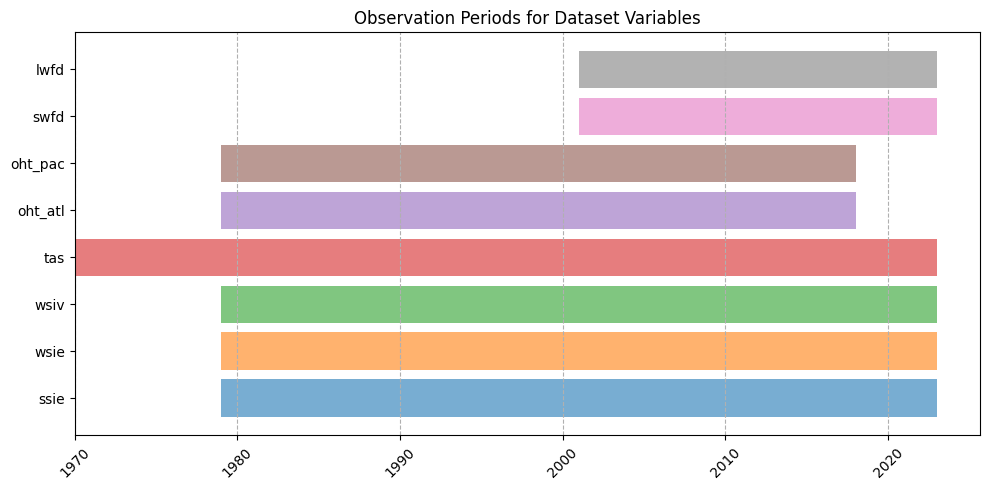

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))

for i, (var, obs_series) in enumerate(observations.items()):
    start = obs_series.index[0]
    end = obs_series.index[-1] 
    ax.barh(var, width=(end - start).days, left=start, alpha=0.6, label=var)

ax.xaxis.set_major_locator(mdates.YearLocator(10))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xticks(rotation=45)

plt.grid(axis="x", linestyle="--")
plt.title("Observation Periods for Dataset Variables")
plt.tight_layout()
plt.show()

This graph shows the different time periods for each observational dataset. Temperature has the longest period, spanning over 50 years. LWFD and SWFD have the shortest, as they both begin in 2001 and are just over 20 years long. All other variables start in 1979 and have a period of about 40 years.

<div style="display: none">Ce graphique-ci présente les périodes différentes pour chaque jeu de données d'observation. Le température a la période la plus longue, s'étendant sur plus de 50 ans. LWFD et SWFD ont les périodes les plus courtes, étant donné qu'ils commencent tous les deux en 2001 avec une longeur de plus 20 ans. Toutes les autres variables comment en 1979 pour une période d'environ 40 ans.</div>

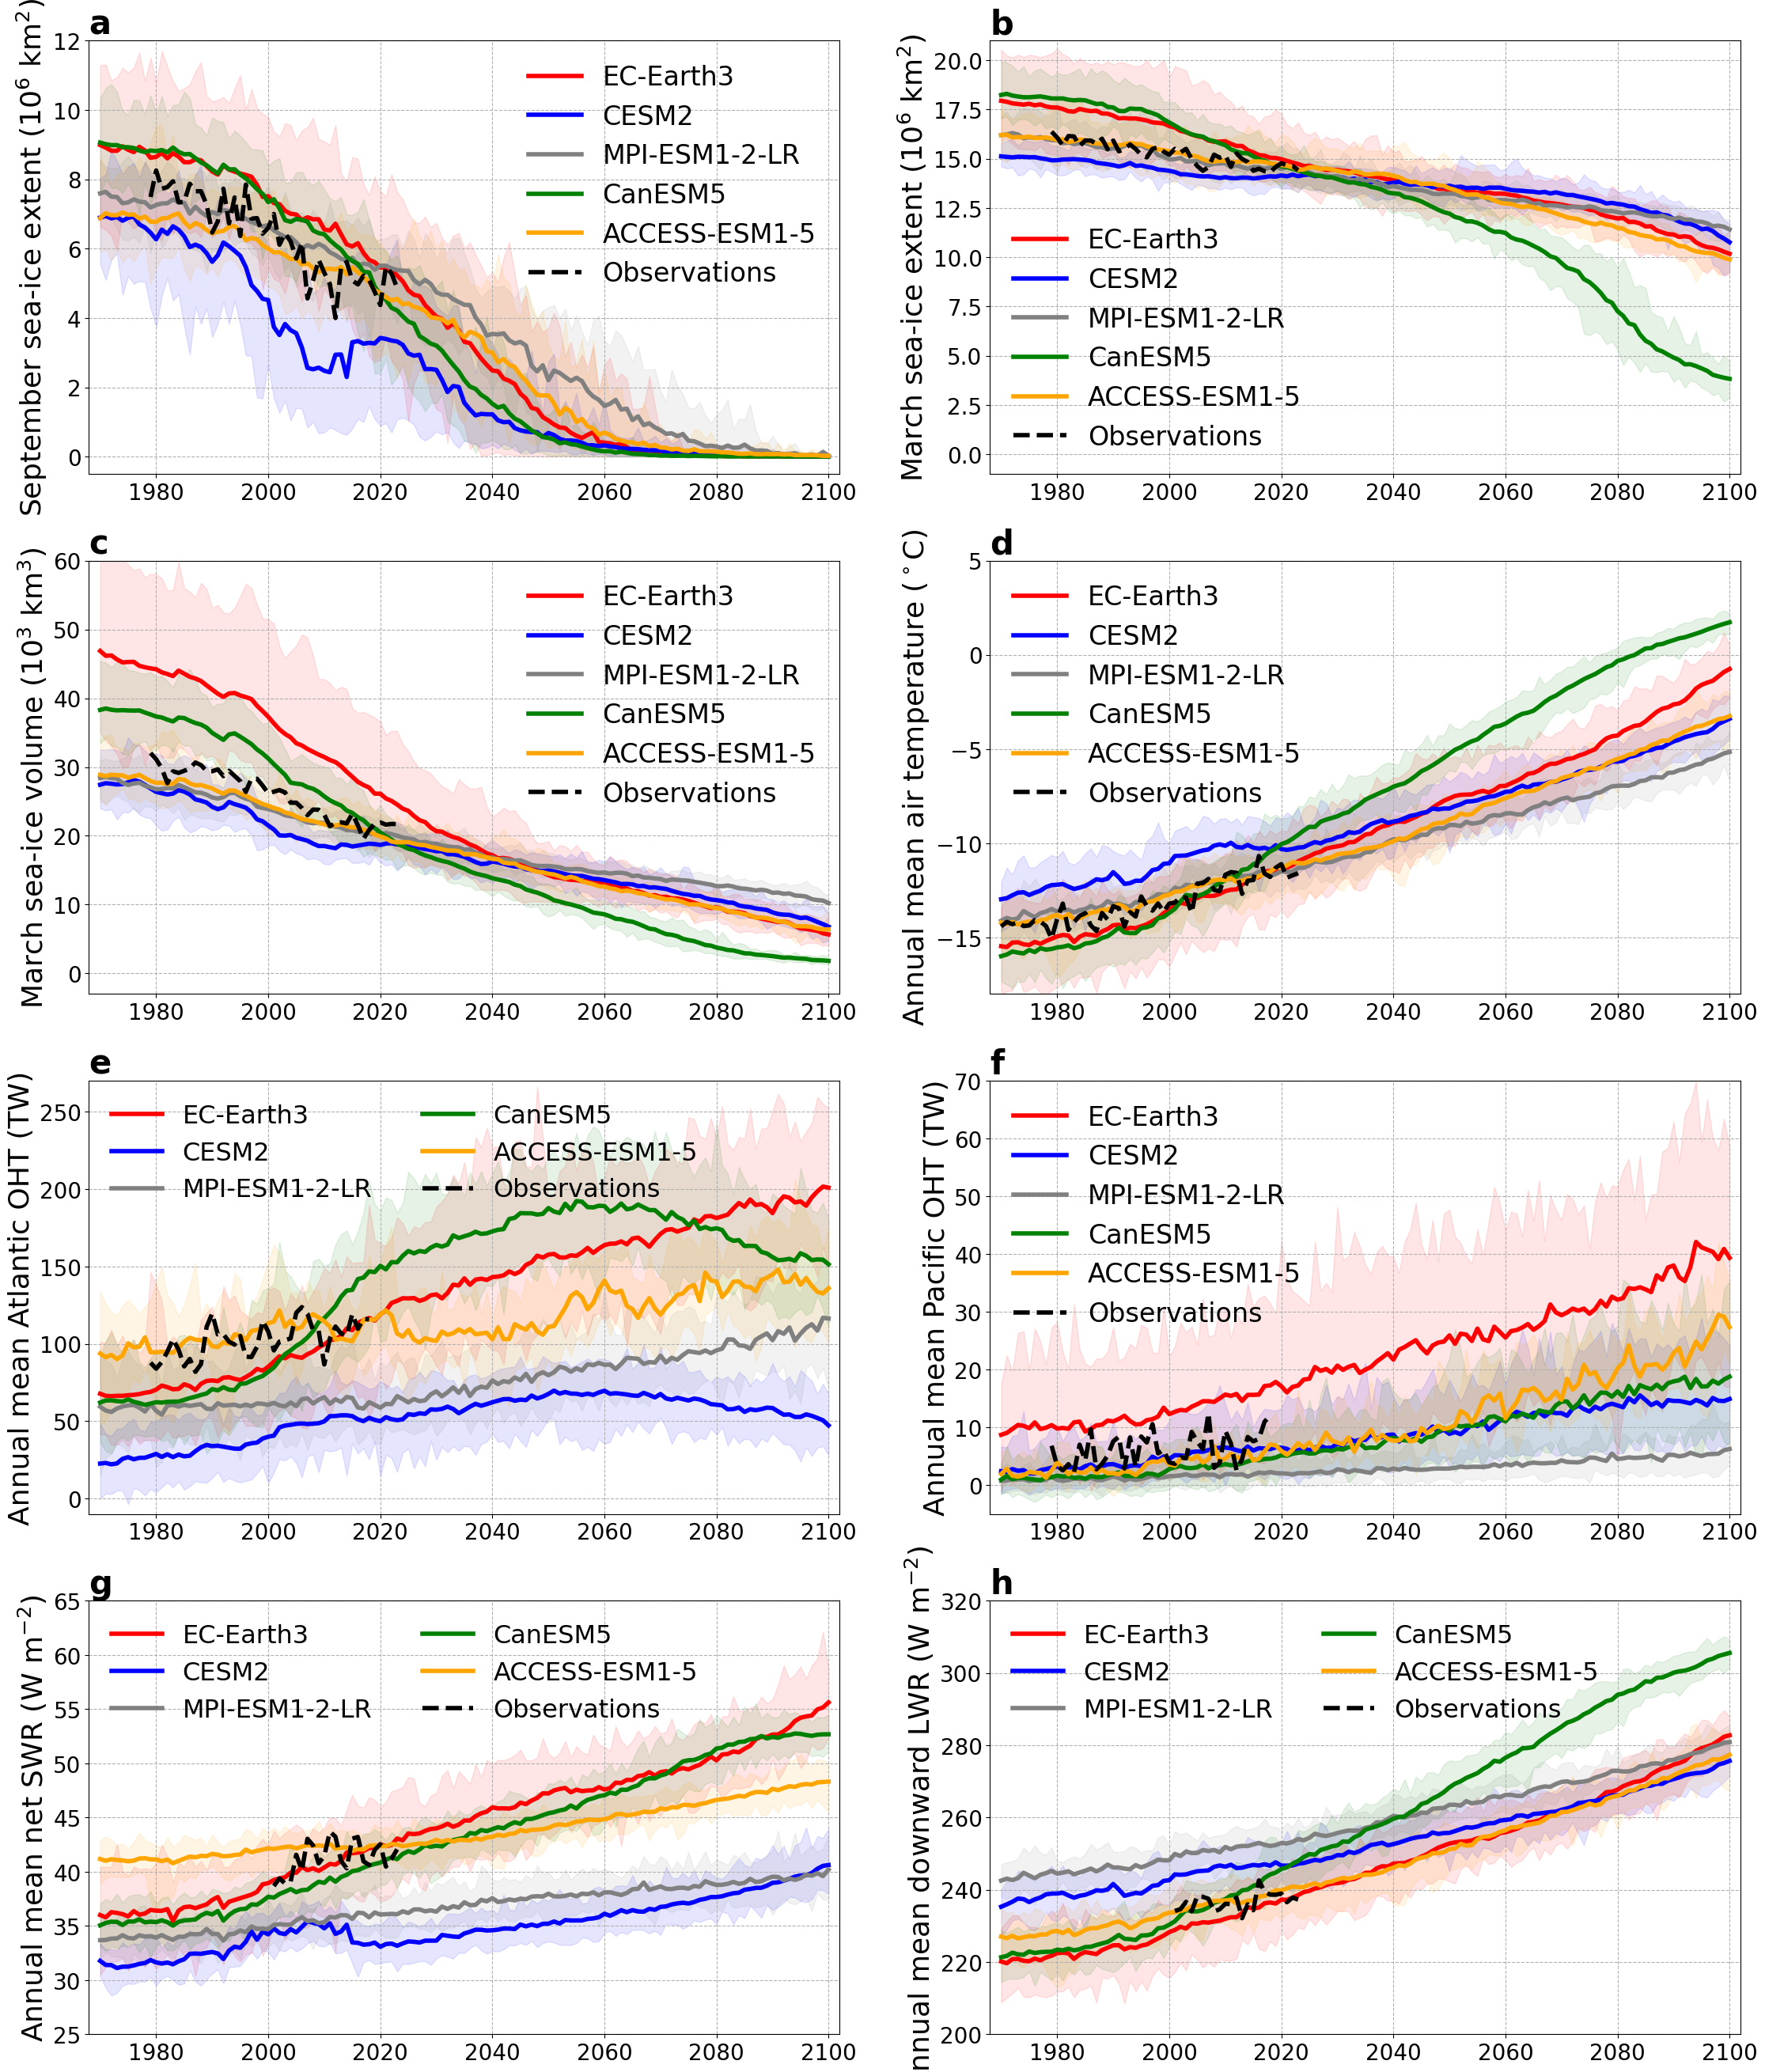

In [6]:
fig,axes = plt.subplots(4,2,figsize=(24,28))
for i, ax in enumerate(axes.flatten()):
    var = VAR_NAMES[i]
    plot_variable(ax, var, model_data[var], VAR_YLABELS[var], i)

fig.subplots_adjust(left=0.08,bottom=0.05,right=0.95,top=0.95,hspace=0.2,wspace=0.2)

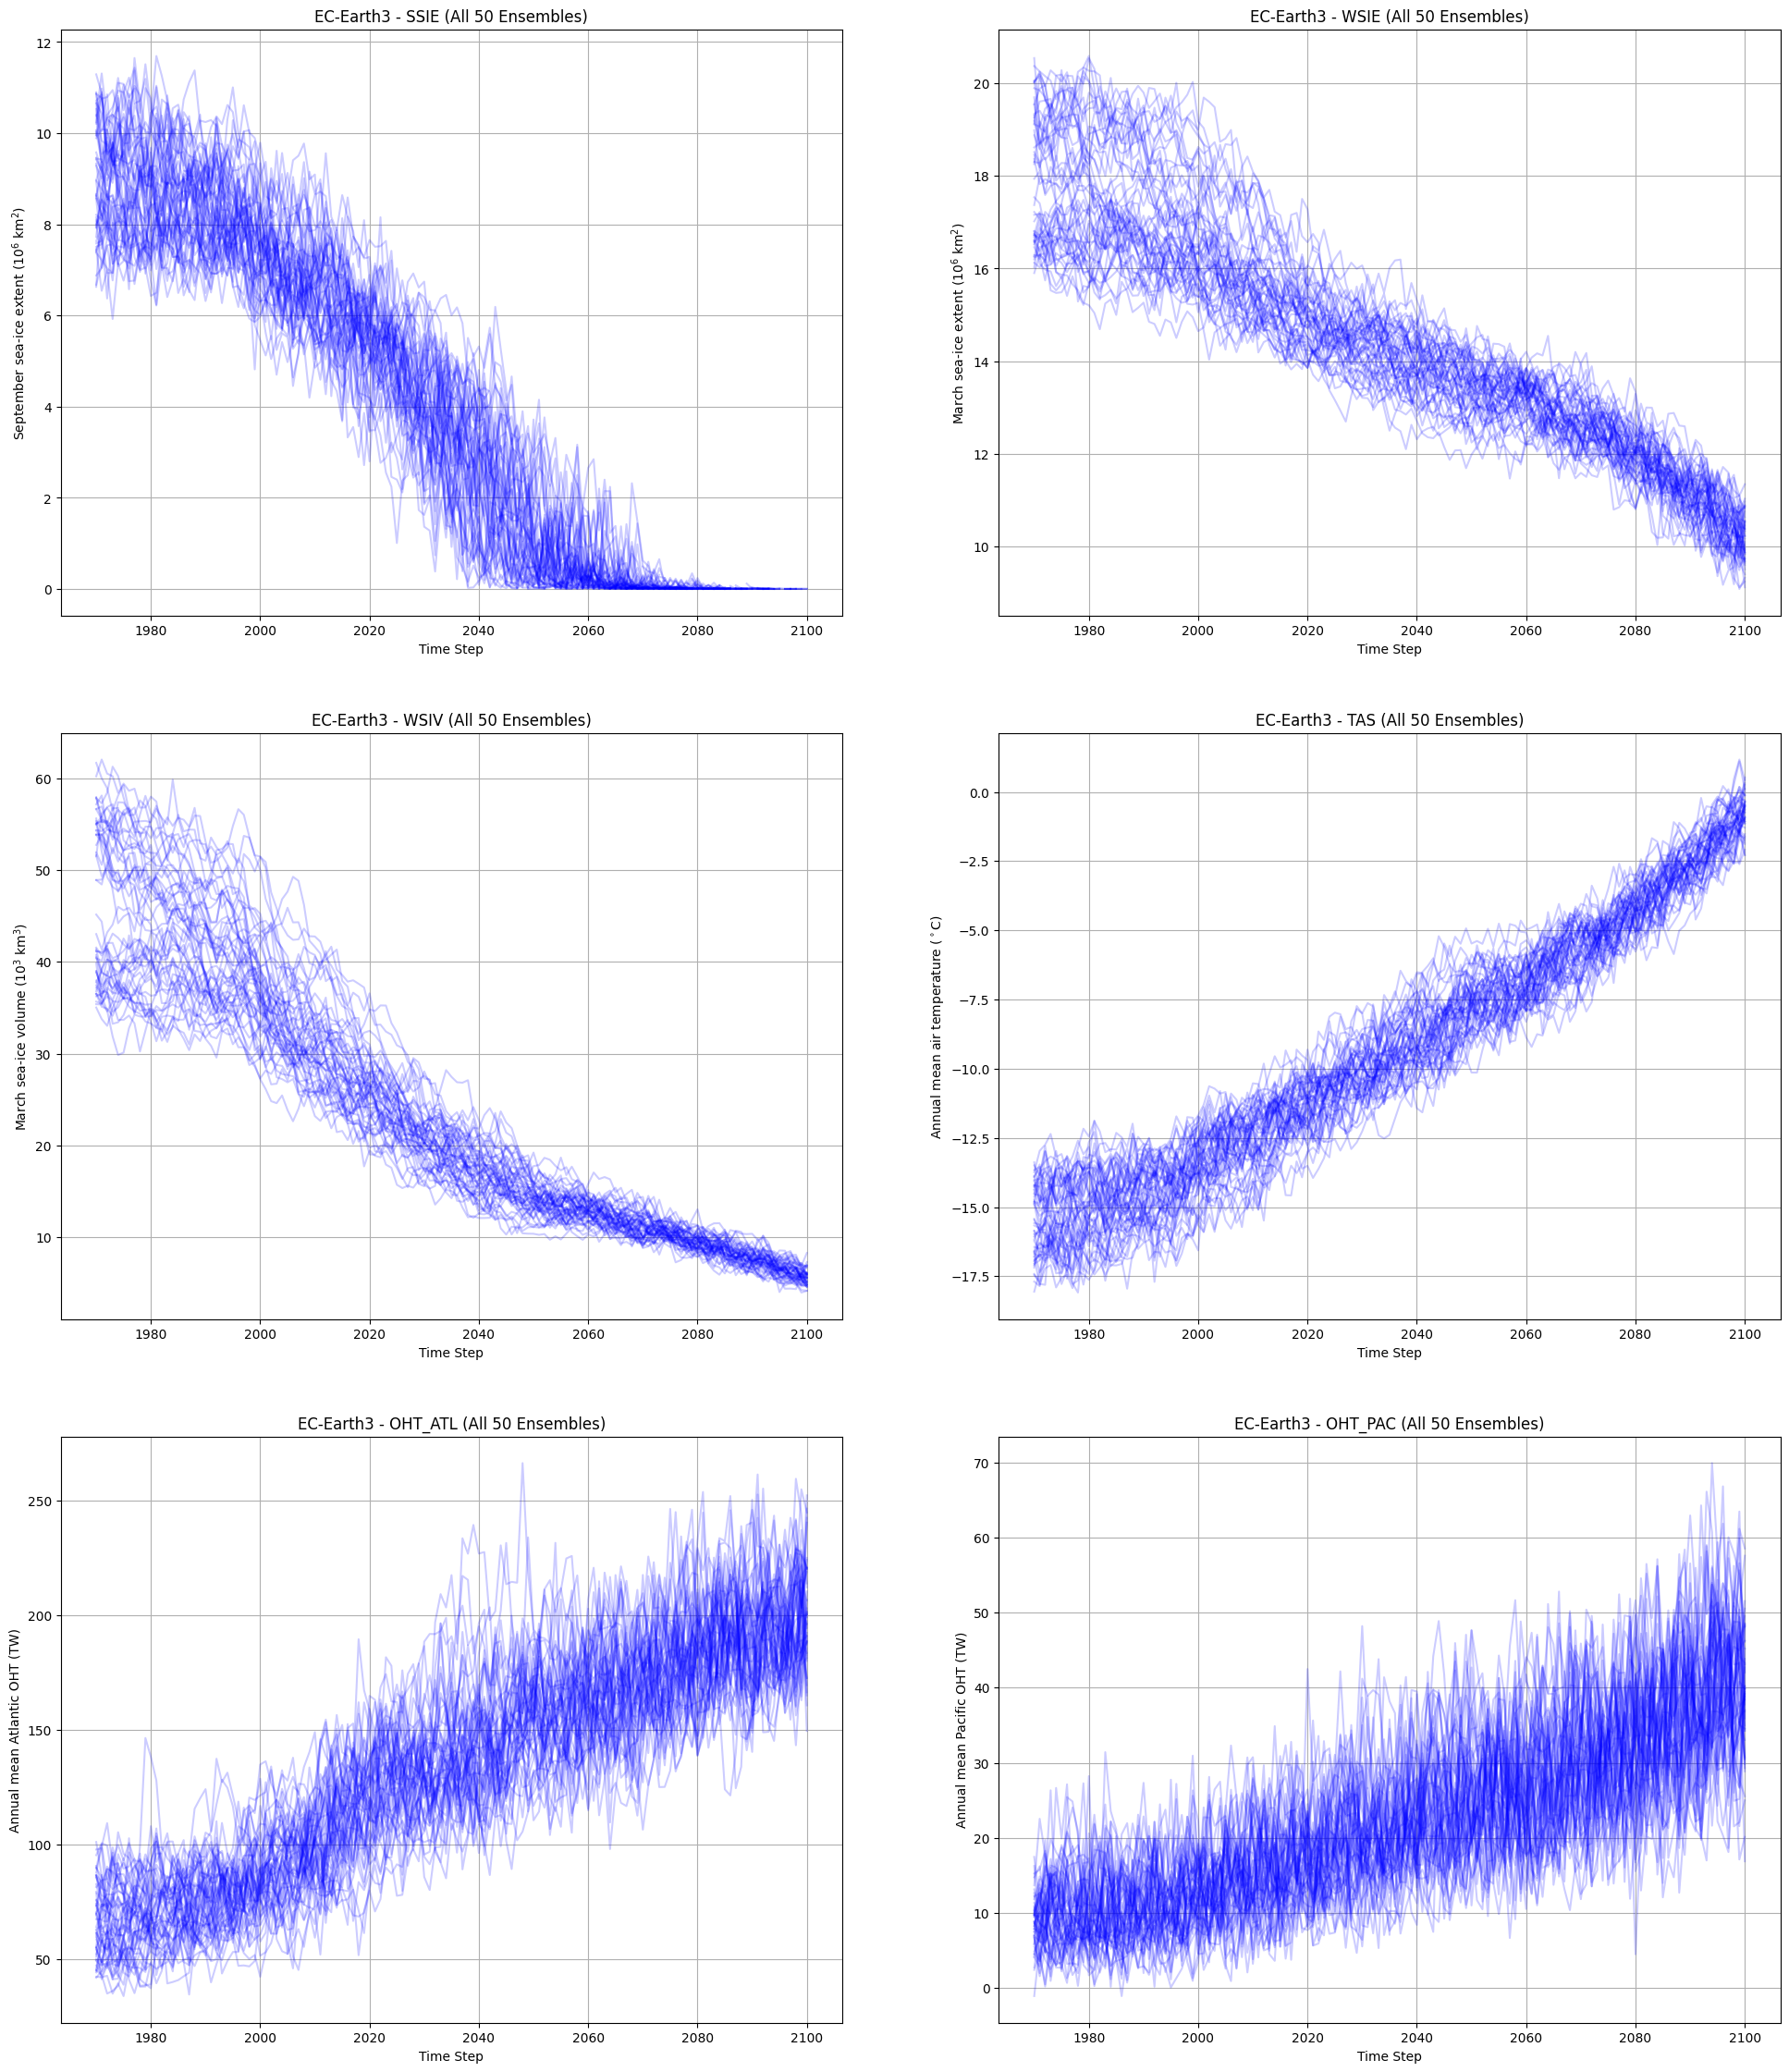

In [7]:
plot_rows = ceil(len(VARIABLES_) / 2)

model = "EC-Earth3" # EC-Earth3, CESM2, MPI-ESM1-2-LR, CanESM5, ACCESS-ESM1-5

fig, axes = plt.subplots(nrows=plot_rows, ncols=2, figsize=(24, 28))
for i, ax in enumerate(axes.flat):
    var = VARIABLES_[i] 
    data = model_data[var][model]
    ax.plot(data, color="blue", alpha=0.2)

    ax.set_title(f"{model} - {var.upper()} (All {data.shape[1]} Ensembles)")
    ax.set_xlabel("Time Step")
    ax.set_ylabel(VAR_YLABELS[var])
    ax.grid(True)

plt.show()

The purpose behind this graph is to examine the distribution of different ensemble realisations for variables of a given model. We wanted to see how the ensembles are distributed between the minimum and maximum, and we note that they are generally distributed uniformly between the extremes. For some models, the spread of the extremes is particularly narrower than others; CanESM5 is notably narrow for both variables, and CESM2 shows a reduced spread for WSIE. In contrast, EC-Earth3 has a fairly wide spread of the extremes. In any case, all models have a tendency to display a small spread around 2100.

<div style="display: none">
L'idée de ce graphique est d'examiner la distribution des réalisations d'ensemble différentes pour les variables d'un modèle donné. On voulait voir comment les ensembles sont distribués entre le minimum et le maximum. On note que les enembles différents pour une variable donnée sont généralement distribués de manière uniforme entre le max et le min. Pour certains modèles, l'écart des extrêmes est particulièrement plus étroit que d'autres ; CanESM5 est notamment étroit pour les deux variables, et CESM2 montre un écart réduit pour WSIE. En revanche, EC-Earth3 présente une différence des extrêmes assez large. En tout cas, tous les modèles a une tendance de converger vers 2100.
</div>

## Biases

In [8]:
# Date strings must have the format "YYYY-MM-DD"
bias_start = "1980-01-01"
bias_end = "2014-01-01"

# Calculate the biases using the model ensemble averages
model_ensemble_avg_biases = {
    var: {
        model: calculate_bias(model_data[var]["Observations"], model_ensemble_avgs[var][model], bias_start, bias_end)
        for model in MODEL_NAMES
    } for var in VARIABLES_
}

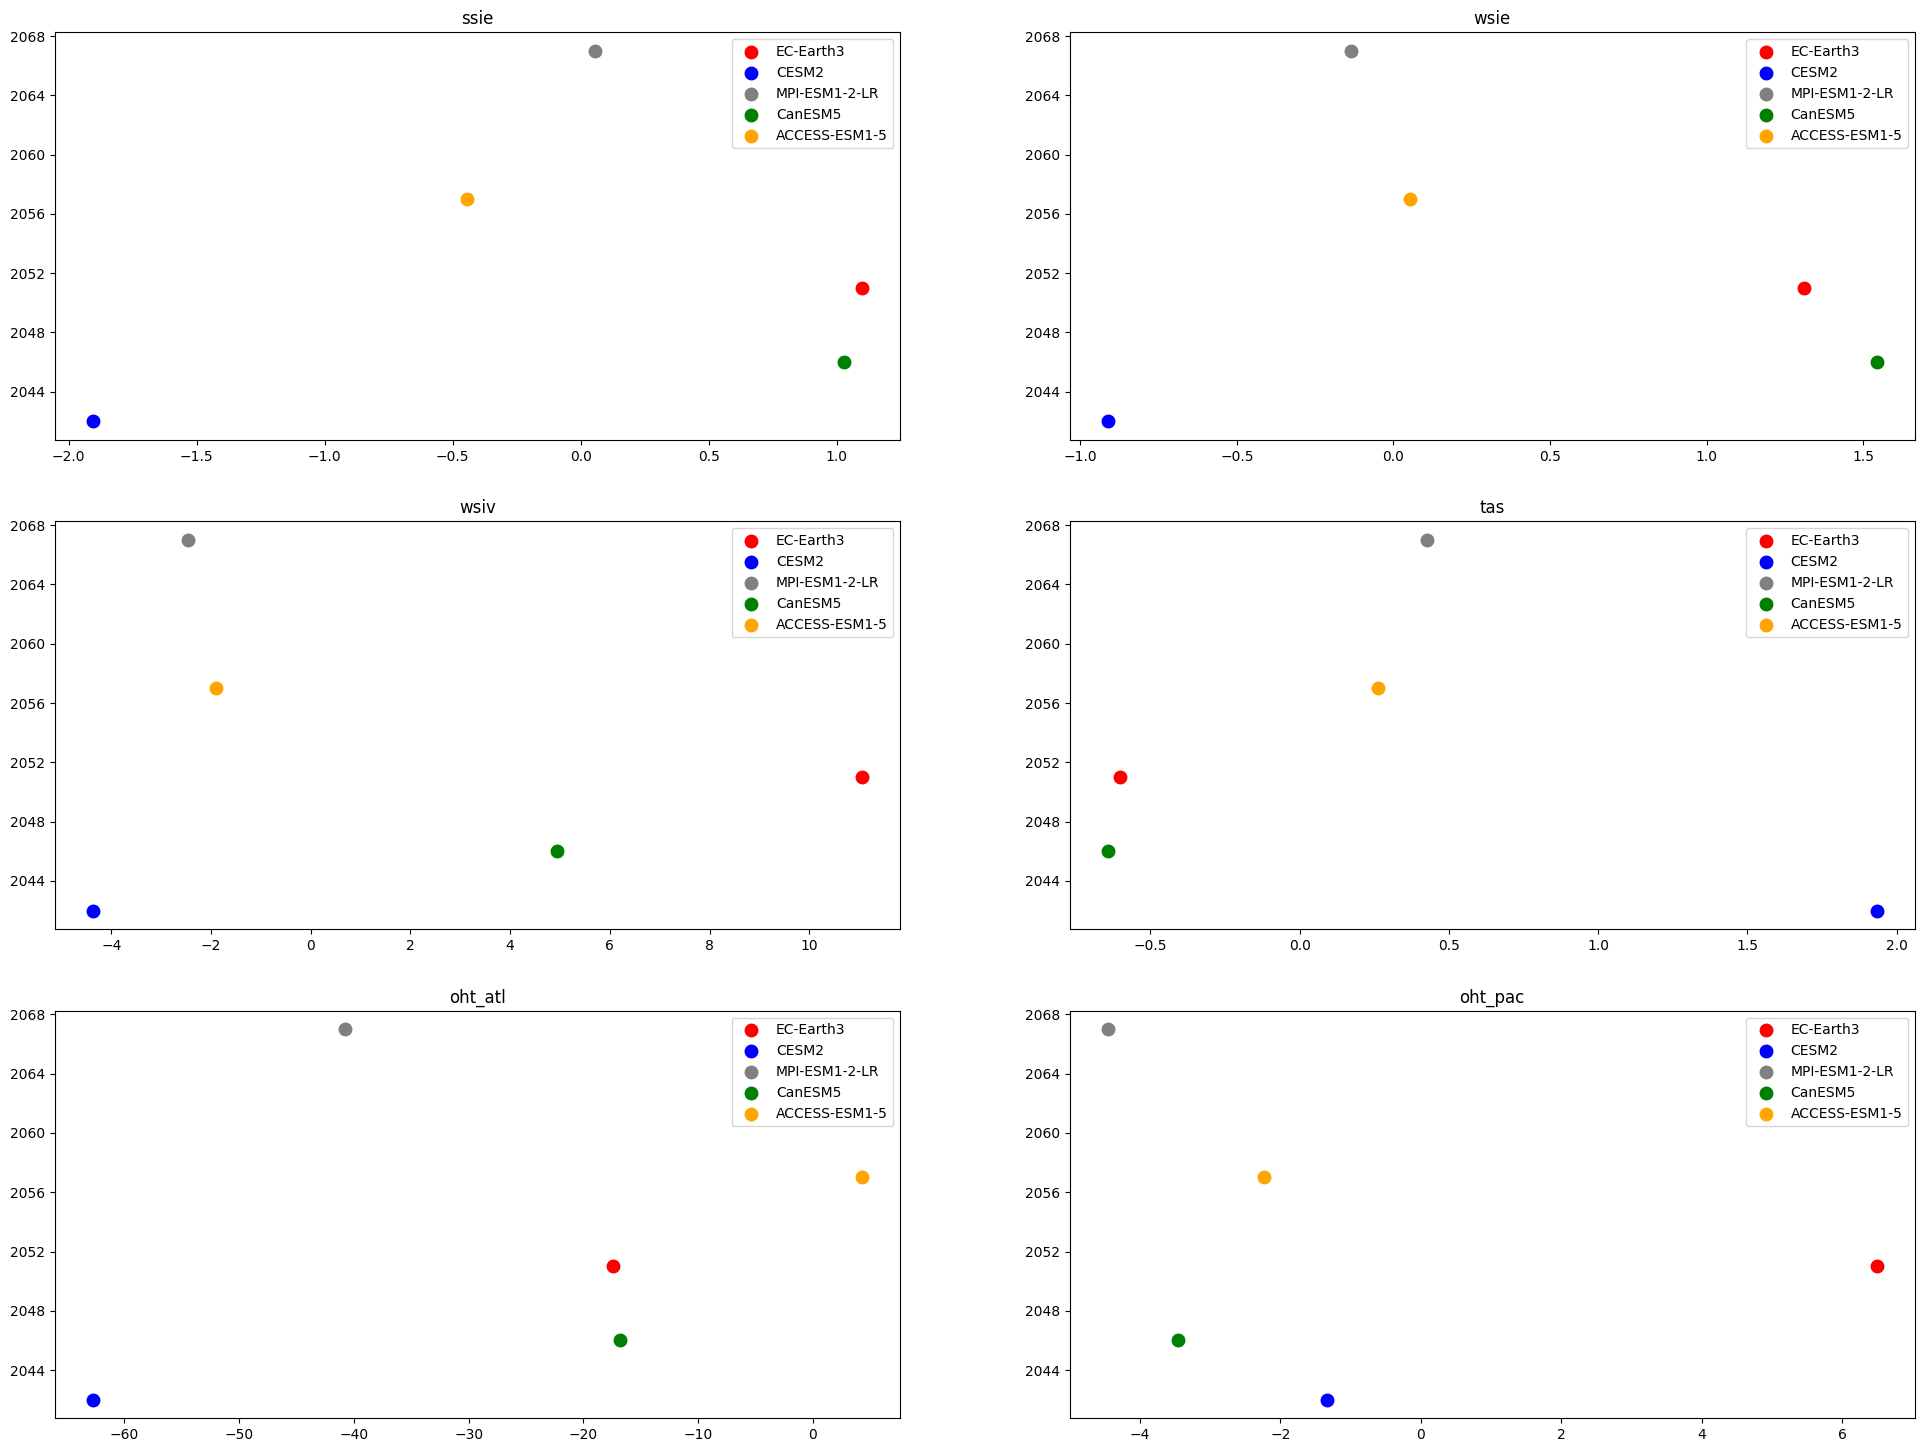

In [9]:
fig,axes = plt.subplots(plot_rows, 2, figsize=(24,18))

y = list(model_ensemble_avg_icefree_years.values())

for i, ax in enumerate(axes.flatten()):
    var = VARIABLES_[i]
    x = list(model_ensemble_avg_biases[var].values())
    for j in range(len(x)):
        model_name = MODEL_NAMES[j]
        ax.scatter(x[j], y[j], color=MODEL_COLOURS[model_name], label=f'{model_name}', linewidths=4)
    ax.set_title(var)
    ax.legend()

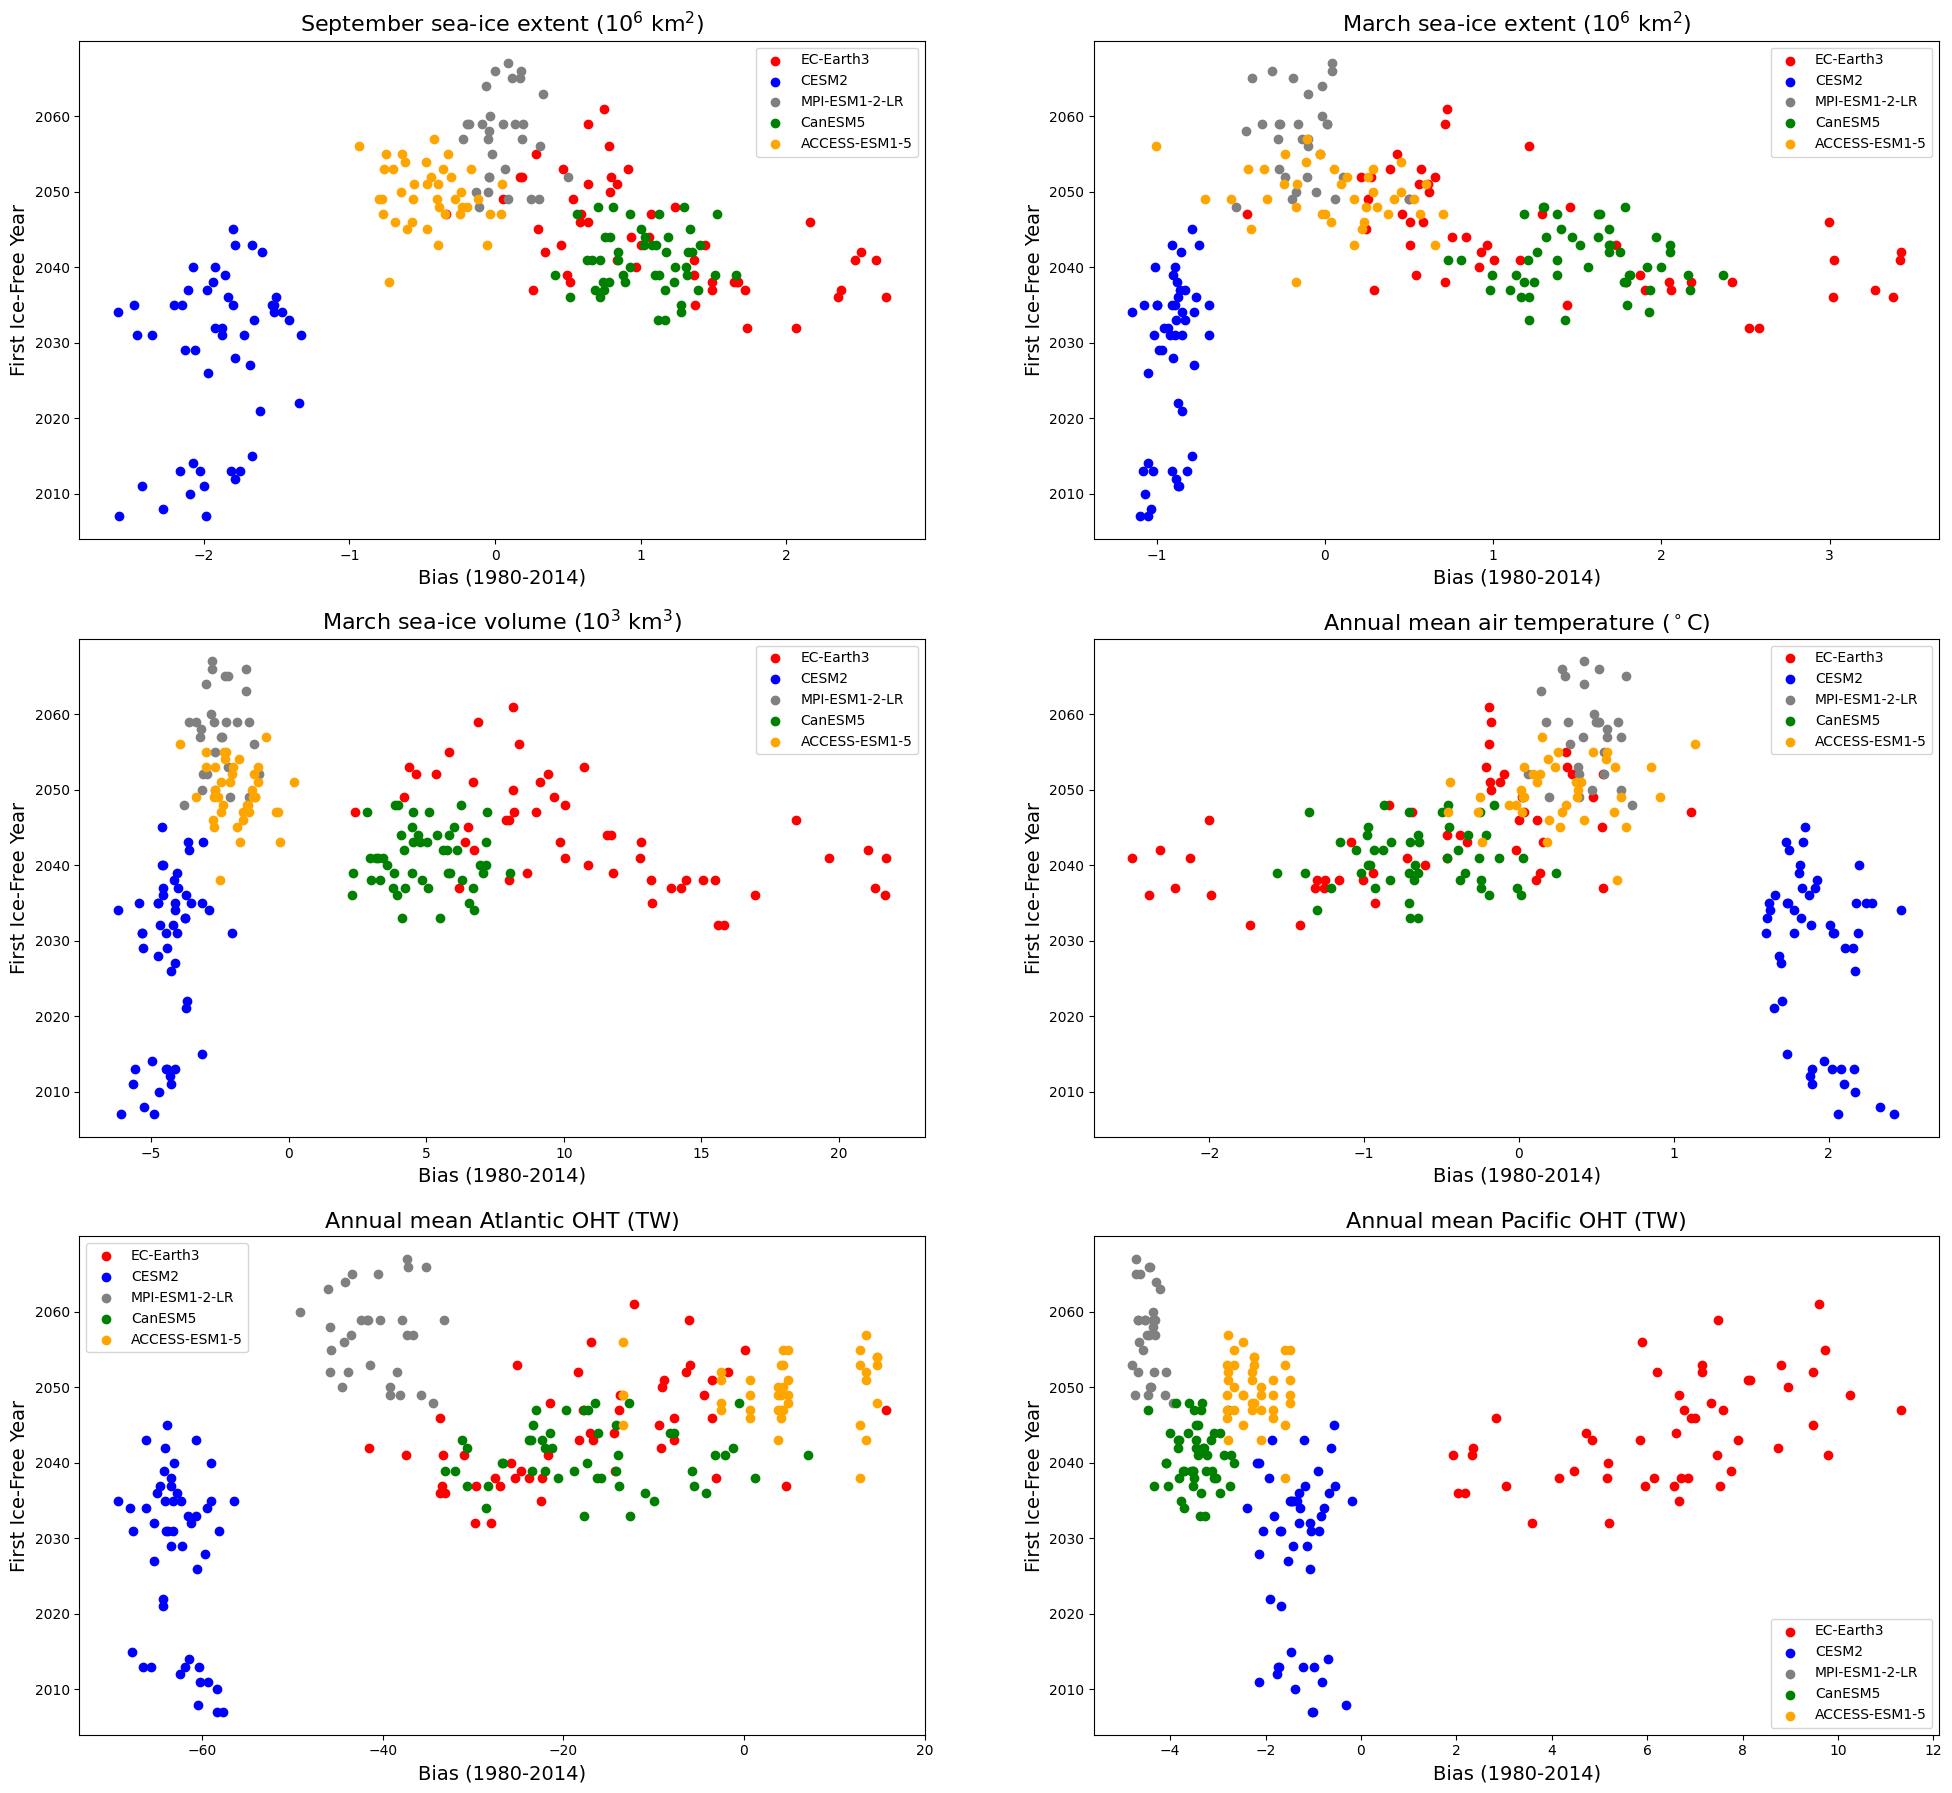

In [10]:
# Calculate the biases of all the model ensembles
model_ensemble_biases = {
    var: {
        model: calculate_bias(model_data[var]["Observations"], model_data[var][model], bias_start, bias_end)
        for model in MODEL_NAMES
    } for var in VARIABLES_
}


fig,axes = plt.subplots(plot_rows,2,figsize=(24,22))

for i, ax in enumerate(axes.flatten()):
    var = VARIABLES_[i]
    for model in MODEL_NAMES:
            ax.scatter(model_ensemble_biases[var][model], model_ensemble_icefree_years[model], c=MODEL_COLOURS[model], label=model)
    ax.legend()
    ax.set_title(VAR_YLABELS[var], fontsize=16)
    ax.set_xlabel("Bias (1980-2014)", fontsize=14)
    ax.set_ylabel("First Ice-Free Year", fontsize=14)

In this graph, we plot the biases of each variable over the period 1980-2014 against the first ice-free year, defined by the first year when the summer sea ice extent falls below 1 million km².

For the summer sea ice extent, we observe a shape resembling an inverted letter "V." The biases of the CESM2 model are all negative and correspond to the earliest first ice-free years. However, the most positive biases, from the EC-Earth3 and CanESM5 models, also produce relatively early first ice-free years compared to those estimated by models with low biases. The biases found between these two extremes correspond to the latest first ice-free years, namely the ACCESS-ESM1-5 and MPI-ESM1-2-LR models. This corresponds to what we see in figure X (David's plot); models with high bias, whether negative or positive — that is, EC-Earth3, CanESM5, and CESM2 — tend to underestimate the first ice-free year.

We see a similar pattern for the winter sea ice extent, corresponding to what is shown in figure X; EC-Earth3 and CanESM5 overestimate the observations, while CESM2 underestimates them, and ACCESS-ESM1-5 as well as MPI-ESM1-2-LR match the observations well. The structure of the first ice-free years for this variable remains the same because it is still based on the summer sea ice extent.

The winter sea ice volume shows a similar pattern to the previous variables, although this time the ACCESS-ESM1-5 and MPI-ESM1-2-LR models exhibit higher biases.

For the annual temperature, we observe a pattern similar to the previous figures, but the models with negative and positive biases are reversed. CESM2 is positive, whereas EC-Earth3 and CanESM5 are negative.

The ocean heat transport variables show completely different patterns. In the figure of Atlantic OHT, we still see that CESM2 shows strong negative biases, but this is also the case for MPI-ESM1-2-LR, leading to a situation where the latest first ice-free years are associated with strong biases. In this figure, the lowest biases come from ACCESS-ESM1-5, EC-Earth3, and CanESM5.


<div style="display: none">Dans ce graphique, nous traçons les biais de chaque variable sur la période de 1980-2014 contre la première année sans glace, indiqué par la première année quand l'étendue de la glace de mer en été atteint moins de 1M km2. 

Pour l'étendue de la grace de mer en été, nous voyons une forme plutôt comme la lettre v à l'envers. Les biais du modèle CESM2 sont tous négatifs, et correspondent aux premières années sans glace les plus tôts. Cependant, les biais les plus positifs, des modèles EC-Earth3 et CanESM5, génèrent également les premières années sans glace assez tôts, par rapport à celles éstimées par les modèles des biais faibles. Les biais trouvés entre les deux extrêmes donnent les premières années sans glace les plus tards, à savoir les modèles ACCESS-ESM1-5 et MPI-ESM1-2-LR. Tout cela corrspond à ce que nous voyons sur la figure X ; les modèles présentant un bias élevé, qu'il soit négatif ou positif, à savoir EC-Earth3, CanESM5, ainsi que CESM2, tendent à sous-estimer la première année sans glace.

Nous voyons une forme similaire pour l'étendue de la glace de mer en hiver, correspondant à ce qui est vu sur la figure X ; EC-Earth3 et CanESM5 sur-estiment les observations, tandis que CESM2 les sous-estiment, et ACCESS-ESM1-5 ainsi que MPI-ESM1-2-LR suivent bien les obseravations. La structure des premières années sans glace pour cette variable reste pareil parce qu'on utilise encore celles basées sur l'étendue de la glace de mer en été.

La volume de glace de mer en hiver présente un figure similaire aux variables précédentes, même si cette fois-ci, les modèles ACCESS-ESM1-5 et MPI-ESM1-2-LR présente des biais plus élevés. 

Pour la température annuelle, on voit une forme similaire aux figures précédentes, mais les modèles de biais négatifs et positifs sont à l'enverse. CESM2 est positif, tandis que EC-Earth3 et CanESM5 sont négatifs. 

Les variables de transport de chaleur océanique présentent des formes complétement différentes. Dans la figure d'OHT atlantique, on voit encore que CESM2 montre des biais fort négatifs, mais c'est également le cas pour MPI-ESM1-2-LR, menant à une situation où les premières années sans glaces les plus tards sont associées à un biais fort. Dans cette figure, les biais les plus faibles proviennent de ACCESS-ESM1-5, EC-Earth3 et CanESM5.</div>



## Autocorrelation

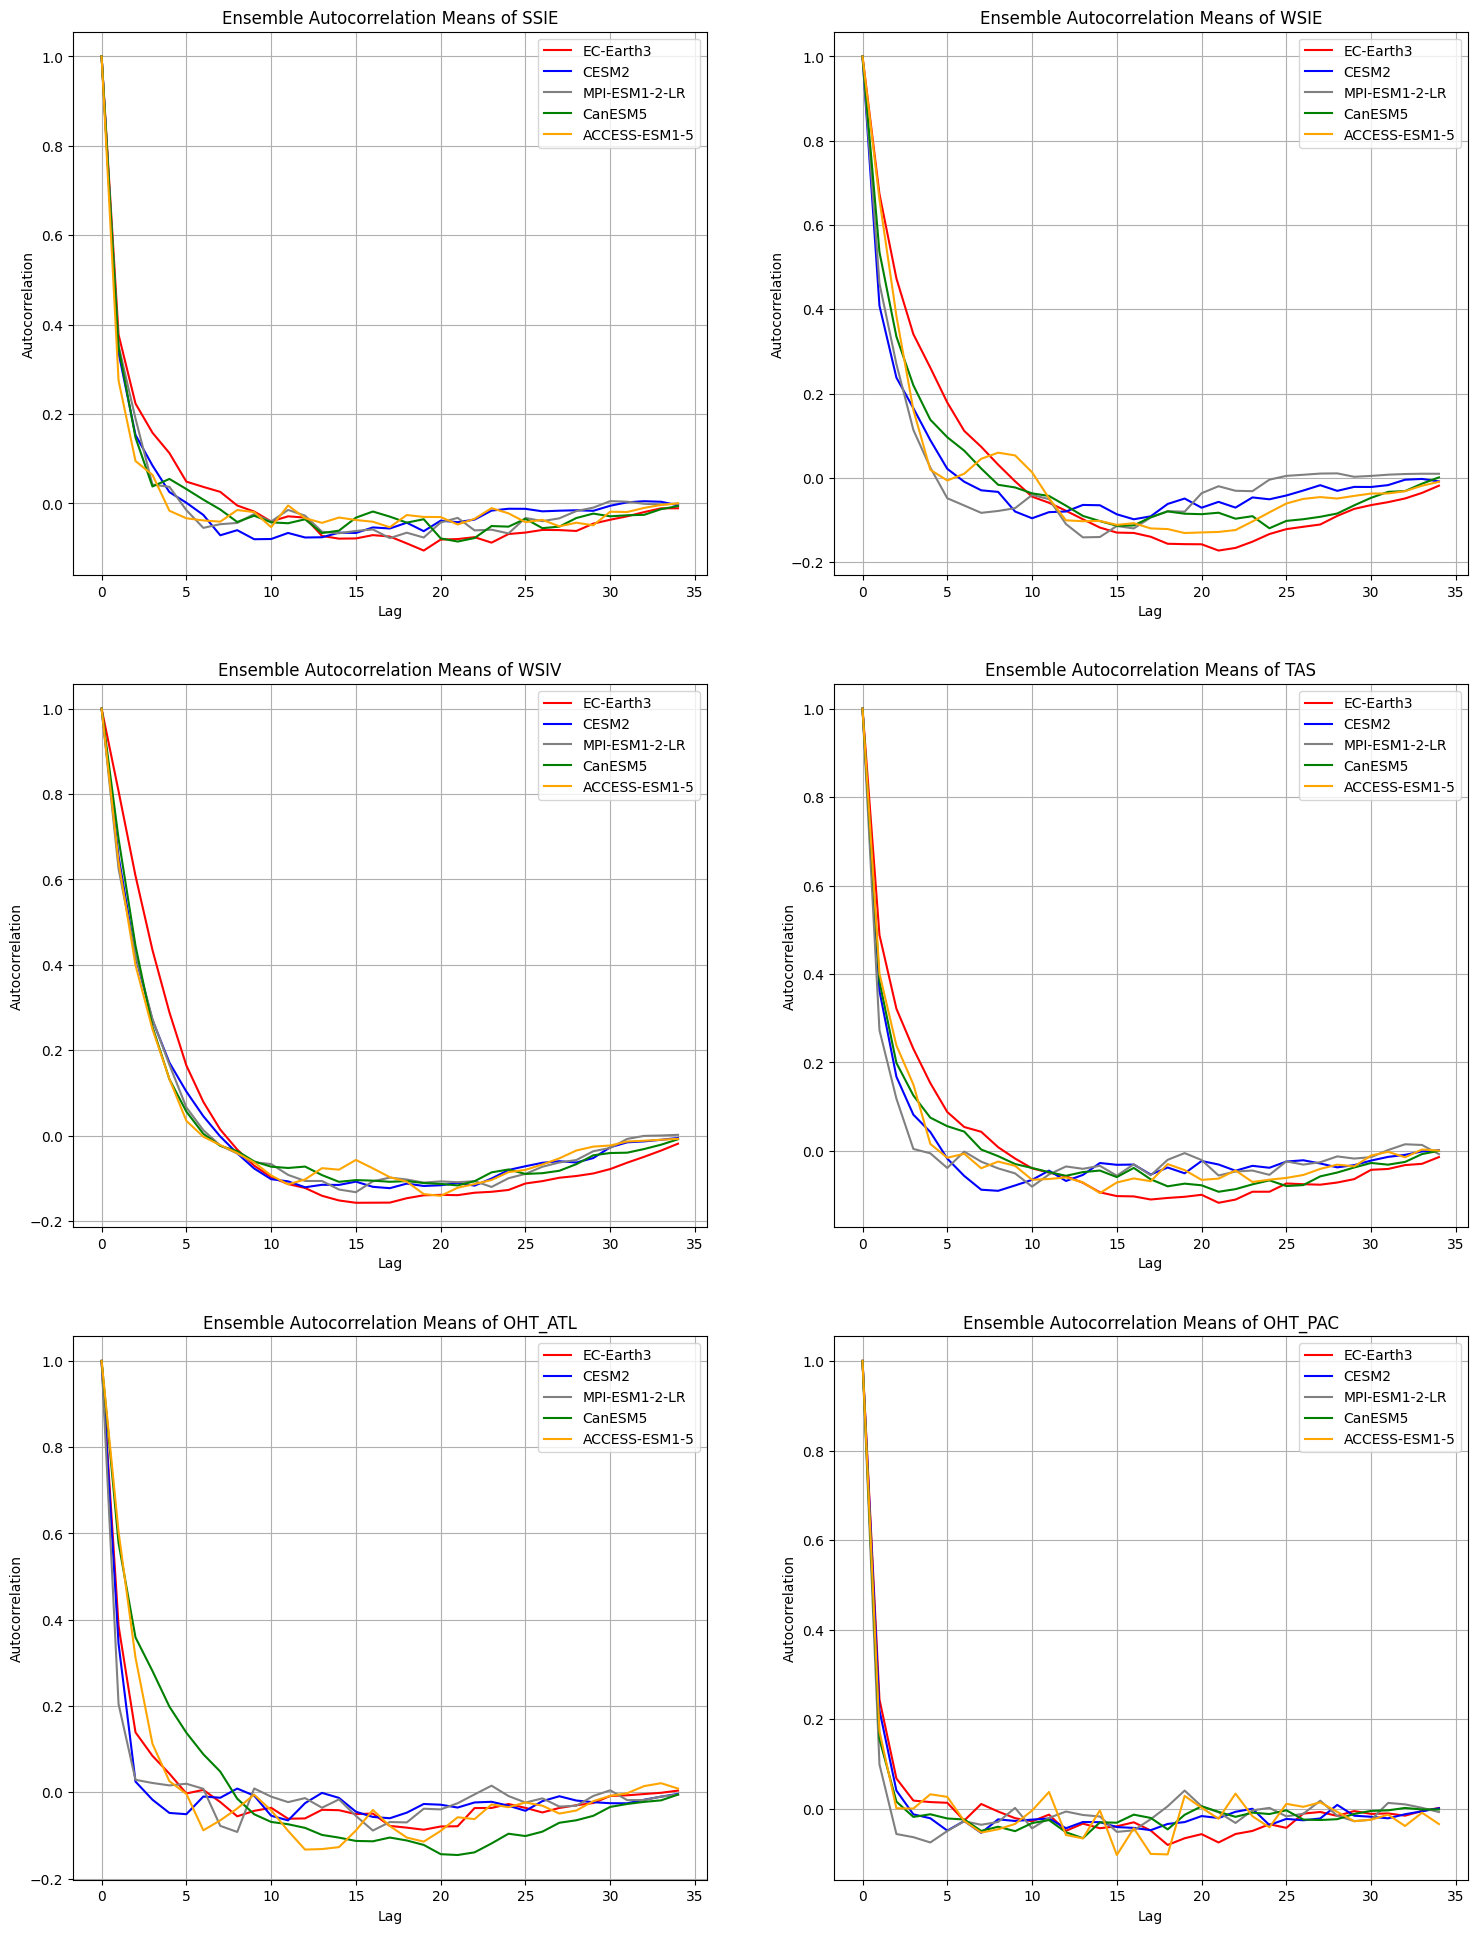

In [11]:
start_year = "1980-01-01"
end_year = "2014-01-01"


fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 24))

for i, ax in enumerate(axes.flat):
    var = VAR_NAMES[:-2][i]

    for model in MODEL_NAMES:
        filtered = filter_by_years(model_data[var][model], start_year, end_year)
        detrended = filtered.subtract(filtered.mean(axis=1), axis=0)
        acf_df = detrended.apply(lambda x: acf(x, nlags=100))
        ensemble_mean = acf_df.mean(axis=1)

        ax.plot(range(len(ensemble_mean)), ensemble_mean, color=MODEL_COLOURS[model], label=model)

    ax.legend(loc='upper right')
    ax.set_xlabel('Lag')
    ax.set_ylabel('Autocorrelation')
    ax.set_title(f'Ensemble Autocorrelation Means of {var.upper()}')
    ax.grid(True)



For SSIE and WSIE, the autocorrelation decreases rapidly, becoming negligible after a lag of between 5 and 10 years. However, WSIE shows a slightly more persistent memory, with a wider range across models for when the autocorrelation reaches zero. Additionally, after crossing zero autocorrelation, the autocorrelations are more negative for WSIE.

WSIV follows a similar dynamic, especially to WSIE, although the range across models is narrower, and the persistence is more negative.

For TAS, the overall shape closely follows that of SSIE in terms of the first lag when autocorrelations reach zero and the range of values across models.

For OHT\_PAC, the decay is particularly pronounced, showing a weak memory in the time series.

Overall, we see that that the autocorrelations are relatively the same across different models for a given variable.


<div style="display: none">Pour SSIE et WSIE, l’autocorrélation décroît rapidement, devenant négligeable après un lag d'entre 5 et 10 ans. Cepedant, WSIE présente une mémoire légèrement plus persistente, ayant un éventail plus large à travers les modèles pour quand ils atteignent 0. En plus, après traverser une autocorrélation 0, les autocorrélations sont plus négatives pour WSIE.

Le WSIV suit une dynamique similaire, surtout qu'au WSIE, bien que l'éventail des modèles soit plus étroit, et une persistance plus négatives.

Pour TAS, la forme générale suit celle de SSIE assez prochement, en termes de le premier lag quand les autocorrélations atteignent 0 et l'éventail des valeurs à travers les modèles.

Pour OHT_PAC, la décroissance est particulièrement marquée, montrant une mémoire faible des séries.</div> 

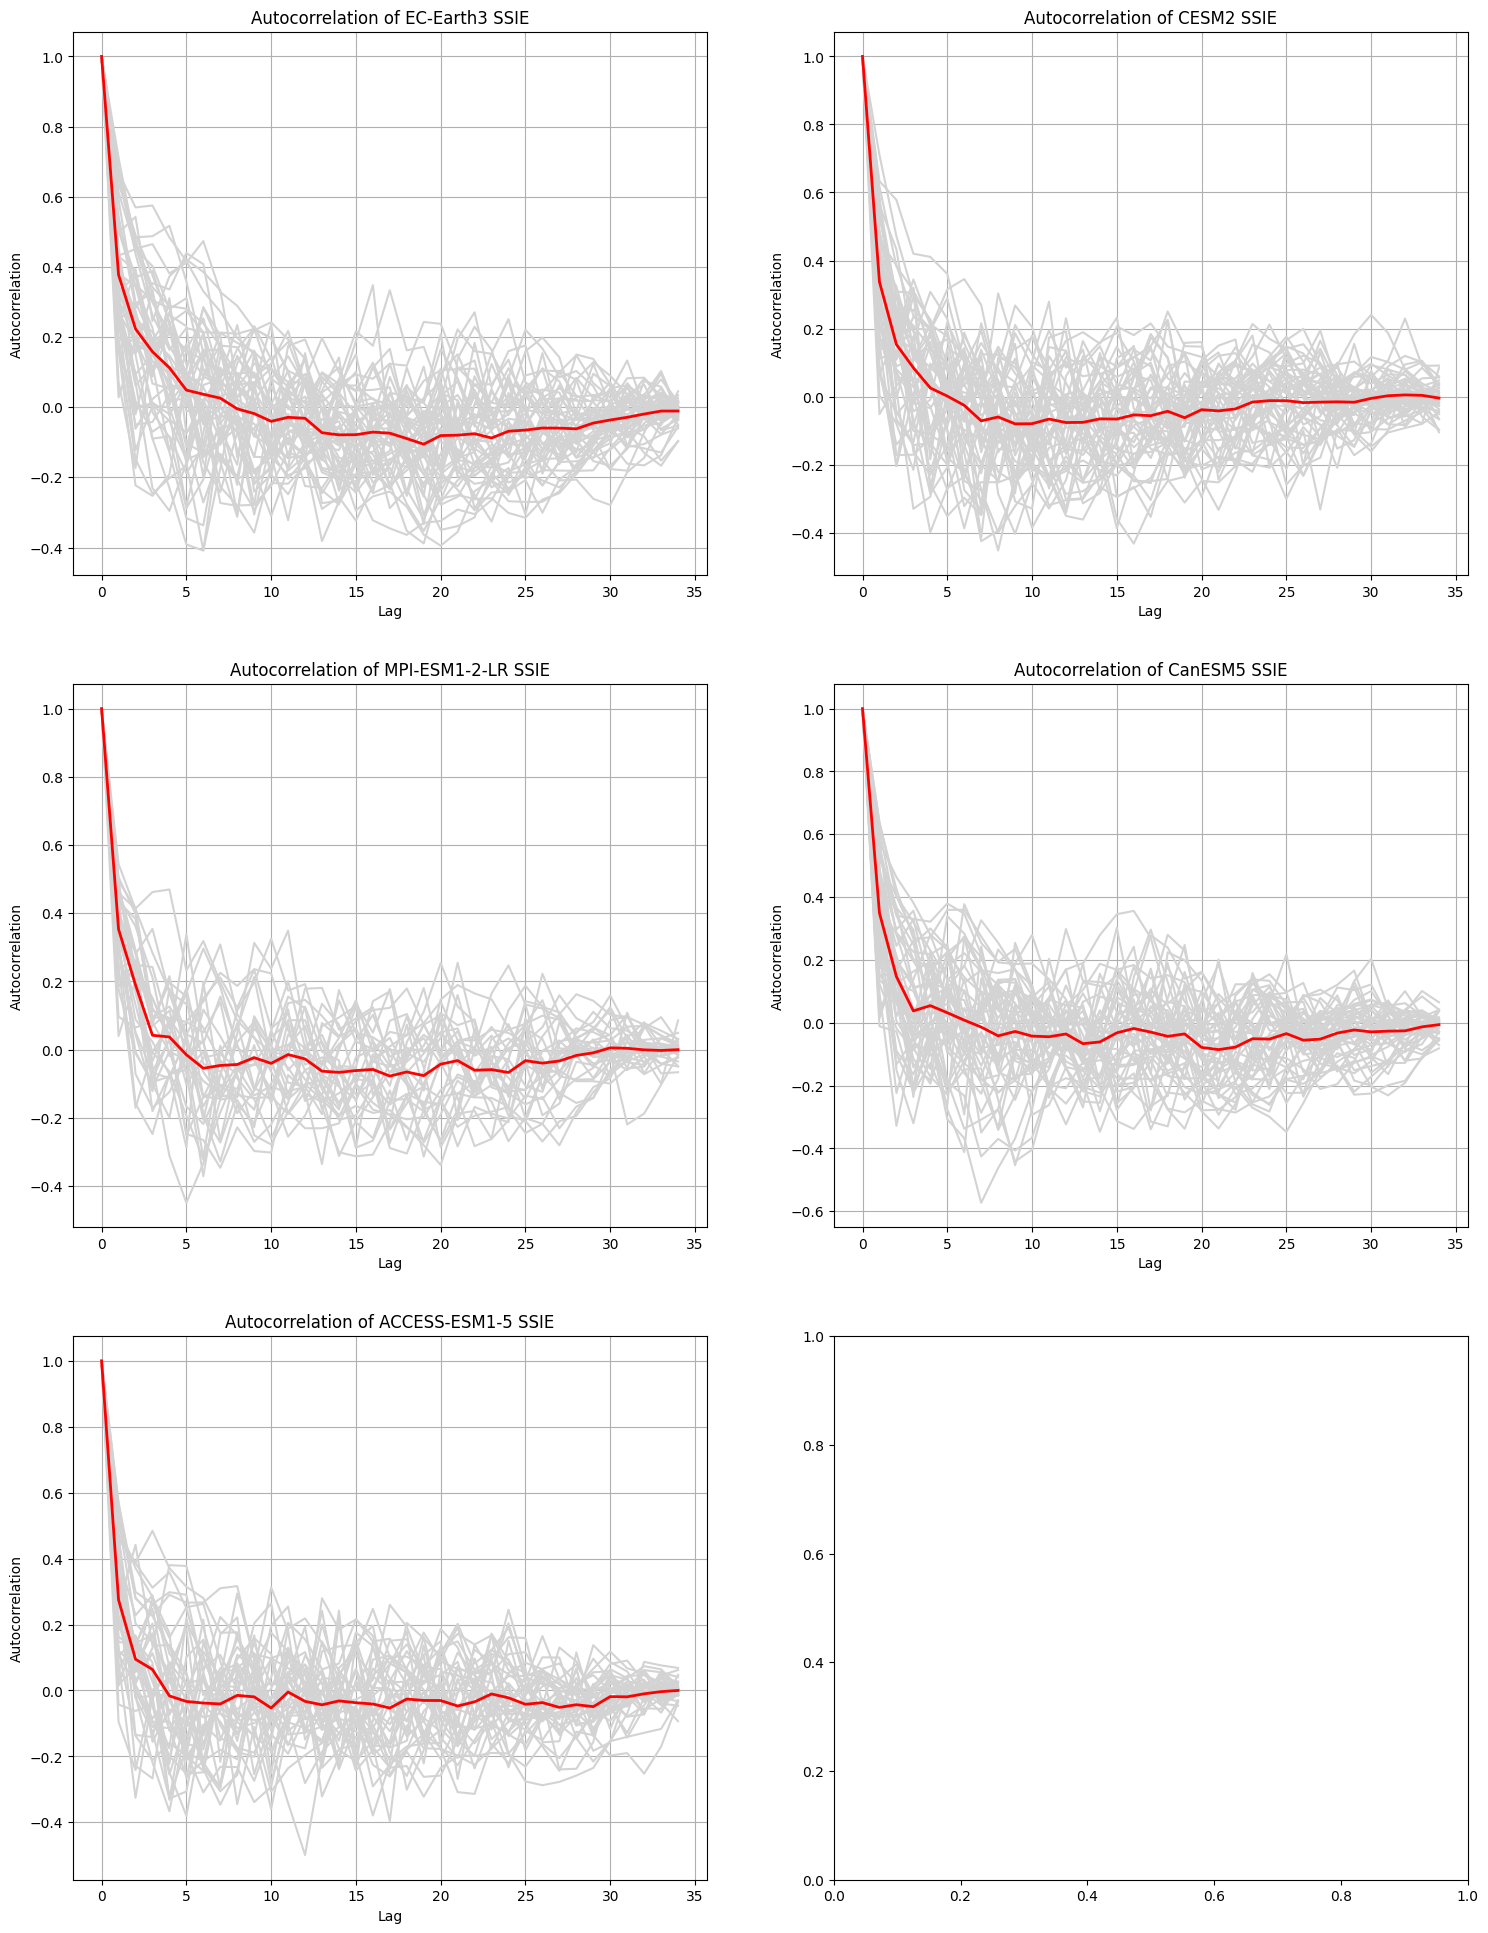

In [82]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 24))

var = "ssie"

for i, ax in enumerate(axes.flat):
    if i == 5:
        break
    var_data = filter_by_years(model_data[var][MODEL_NAMES[i]], start_year, end_year)
    var_detrended = var_data.subtract(var_data.mean(axis=1), axis=0)
    acf_df = var_detrended.apply(lambda x: acf(x, nlags=100))

    ax.plot(range(len(acf_df)), acf_df, color="lightgrey")
    ax.plot(range(len(acf_df)), acf_df.mean(axis=1), color="red", linewidth=2, label='Ensemble Mean')
    ax.set_xlabel('Lag')
    ax.set_ylabel('Autocorrelation')
    ax.set_title(f'Autocorrelation of {MODEL_NAMES[i]} {var.upper()}')
    ax.grid(True)

## Correlation

In [83]:
corr_start_year = "1970-01-01"
corr_end_year = "2060-01-01"

In [84]:
# Calculate the correlations between series like in the article
model_corrs = {}
for var in VAR_NAMES:
    model_corrs[var] = {}
    for model in MODEL_NAMES:
        x = filter_by_years(
            model_data[var][model], corr_start_year, corr_end_year,
        )
        x_detrended = subtract_ensemble_mean(x)

        y = filter_by_years(
            model_data["ssie"][model], corr_start_year, corr_end_year,
        )
        y_detrended = subtract_ensemble_mean(y)

        model_corrs[var][model] = calculate_correlation_ensemble_mean(
            x_detrended, y_detrended, corr_type="pearson",
        )


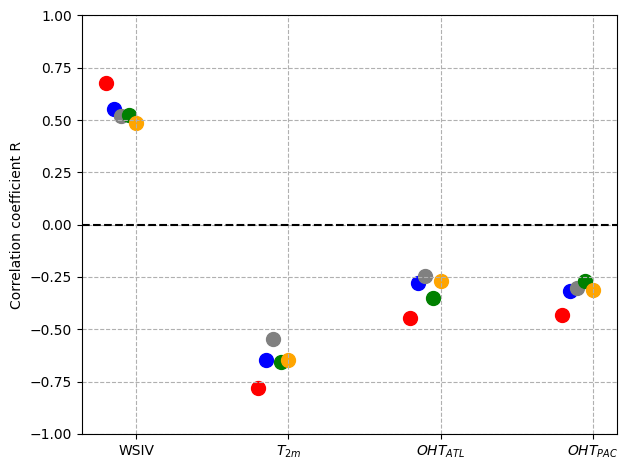

In [85]:

CORR_VARS = ["wsiv", "tas", "oht_atl", "oht_pac"]

fig, ax = plt.subplots()
ax.grid(linestyle='--')

for i, var in enumerate(CORR_VARS):
    for j, model in enumerate(MODEL_NAMES):

        corr = model_corrs[var][model]
        if np.isnan(corr):
            continue
        x = i - 0.2 + j * 0.05

        ax.scatter(x, corr, label=model, c=MODEL_COLOURS[model], s=100)


# Formatage
ax.set_xticks(range(len(CORR_VARS)))
ax.set_xticklabels([VAR_YLABELS_SHORT[var] for var in CORR_VARS])
ax.set_ylabel("Correlation coefficient R")
ax.axhline(0, color='black', linestyle='--')
ax.set_ylim(-1, 1)
ax.grid(linestyle='--')

plt.tight_layout()
plt.show()


The plot is fairly similar to what is in the article, though there are slight differences. It might be just be a scaling issue, but the correlations for OHT_ATL and OHT_PAC are closer to zero in the artle.

## Causality (Incomplete)

In [12]:
def check_5pc_significance(tau21: float, error_tau21: float) -> bool:
    return not ((tau21 - 1.96 * error_tau21) < 0 < (tau21 + 1.96 * error_tau21))

def prepare_for_liang(var: str, model: str, start: str, end: str) -> DataFrame:
    filtered = filter_by_years(model_data[var][model], start, end)
    return subtract_ensemble_mean(filtered).to_numpy() 


In [ ]:


res_names = ["T21","tau21","error_T21","error_tau21","R","error_R","error_T21_FI"]
dt = 1
n_iter = 1000
liang_start = "1970-01-01"
liang_end = "2060-01-01"

ssie_liang = prepare_for_liang('ssie', model, liang_start, liang_end)

In [17]:
model = 'CESM2' # EC-Earth3, CESM2, MPI-ESM1-2-LR, CanESM5, ACCESS-ESM1-5
var = "tas"

var_liang = prepare_for_liang(var, model, liang_start, liang_end)

liang_indexes = []
df_in = []
for i in range(ssie_liang.shape[1]):
    x1 = var_liang[:, i]
    x2 = ssie_liang[:, i]
    res = dict(zip(
        res_names,
        compute_liang(x2, x1, dt, n_iter),
    ))
    df_in.append(res)
    confident = check_5pc_significance(res["tau21"], res["error_tau21"])
    if confident:
        liang_indexes.append(res["tau21"])

tau_avg = np.nanmean(abs(np.array(liang_indexes)))

I have not been able to reproduce the results from the article.

In [18]:
tau_avg

np.float64(15.393928986054087)

## PCA (In Progress)

In [89]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

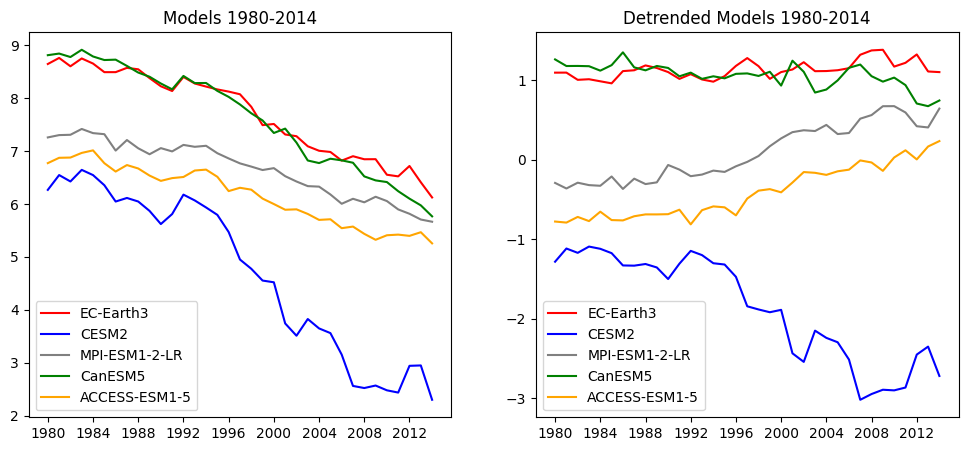

In [137]:
pca_start = "1980-01-01"
pca_end = "2014-01-01"

ssie_df = filter_by_years(DataFrame(model_ensemble_avgs["ssie"]), pca_start, pca_end)
ssie_detrended = subtract_ensemble_mean(ssie_df)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for col, color in zip(ssie_df.columns, MODEL_COLOURS.values()):
    axes[0].plot(ssie_df.index, ssie_df[col], label=col, color=color)
axes[0].set_title("Models 1980-2014")
axes[0].legend()

for col, color in zip(ssie_detrended.columns, MODEL_COLOURS.values()):
    axes[1].plot(ssie_detrended.index, ssie_detrended[col], label=col, color=color)
axes[1].set_title("Detrended Models 1980-2014")
axes[1].legend()

In [138]:
# Fill nans and scale data
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(ssie_detrended)
X_scaled = StandardScaler().fit_transform(X_imputed)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

scores = pd.DataFrame(X_pca, index=ssie_detrended.index, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])
loadings = pd.DataFrame(pca.components_.T, index=ssie_detrended.columns, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])

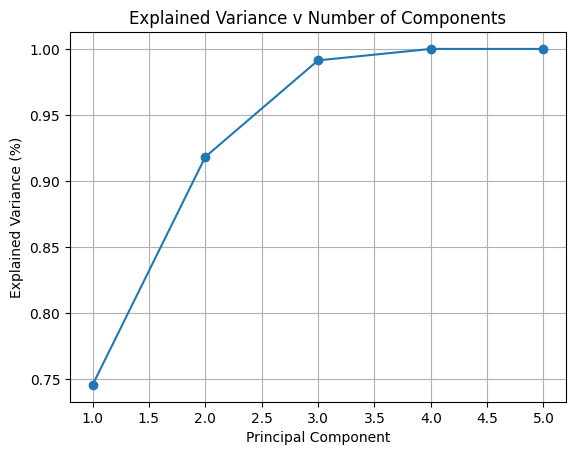

In [139]:
# Scree plot (variance expliquée)
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')
plt.title('Explained Variance v Number of Components')
plt.grid(True)
plt.show()


In [140]:
loadings

PC1       PC2       PC3       PC4       PC5
EC-Earth3      0.361254  0.638084  0.666561  0.035336  0.129583
CESM2         -0.500453 -0.193409  0.303865 -0.009959  0.787214
MPI-ESM1-2-LR  0.503709 -0.019834 -0.299430 -0.691367  0.422182
CanESM5       -0.337457  0.731665 -0.557309  0.085309  0.181432
ACCESS-ESM1-5  0.501440 -0.140408 -0.251217  0.716510  0.390317

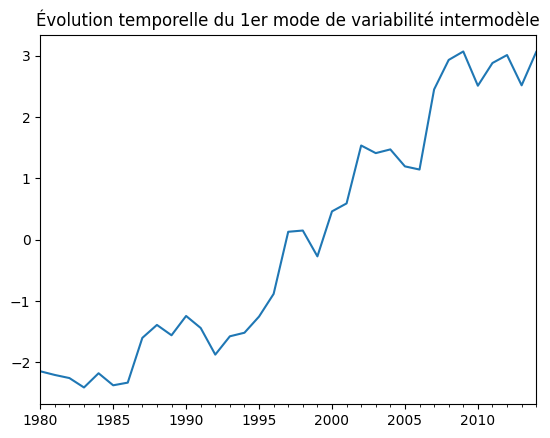

In [142]:
_ = scores['PC1'].plot(title="Évolution temporelle du 1er mode de variabilité intermodèle")

In [148]:
var = "tas"

var_df = filter_by_years(DataFrame(model_ensemble_avgs[var]), pca_start, pca_end)
mmm_deviations = var_df - var_df.mean()

In [149]:
from sklearn.linear_model import LinearRegression

model = "EC-Earth3"

linear_reg = LinearRegression()
X = scores[["PC1", "PC2"]]
y = mmm_deviations[model]
linear_reg.fit(X, y)

y_pred = linear_reg.predict(X)

print("Coefficients:", linear_reg.coef_)
print("Intercept:", linear_reg.intercept_)   

Coefficients: [ 0.49233685 -0.13114571]
Intercept: 4.846297986861164e-16


In [150]:
linear_reg.score(X, y)

0.9625118826075949

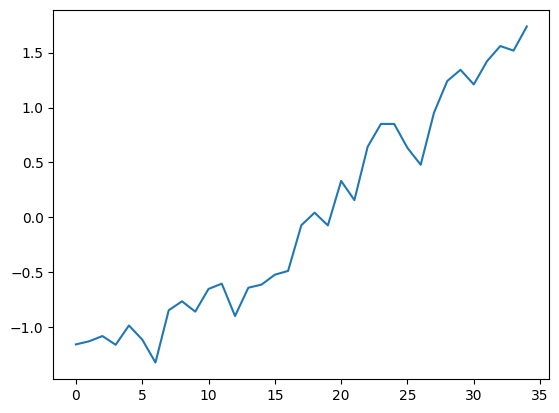

In [151]:
plt.plot(y_pred)